# **Analysis of Art - Classification**

## [CHANGE ME]

In [11]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
dir_model = "/content/drive/MyDrive/Art/01_Model.pt"
dir_dataset = "/content/drive/MyDrive/Art/00_Dataset/"
dir_train_model = "/content/drive/MyDrive/University/Smart Media Technology/models"

## Installation

In [13]:
!pip install -q ray

## Imports

In [14]:
# Python
import argparse
import functools
import glob
import math
from pathlib import Path
import os
import os.path as osp
import sys

# PyTorch
import torch
from torch import nn, optim
import torch.nn as nn
from torch.nn import functional as F
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.transforms import functional as TF
from torch.utils.tensorboard import SummaryWriter

# Various
from ray import tune
from ray.tune import schedulers

## Class: Dataset

In [15]:
class dataset():
    def __init__(self, config):
        self.path = config["path"]
        self.config = config
        self.batch = self.config["batch_size"]
        self.resolution = (self.config["resolution"], self.config["resolution"])

    def normalise(self):
        norm_transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(self.resolution),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(0.4235, 0.2610),
        ])
        train_imagefolder = torchvision.datasets.ImageFolder(self.path +"/train/", norm_transform)
        loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=len(train_imagefolder), num_workers=1)
        data = next(iter(loader))
        self.mean, self.std = data[0].mean(), data[0].std()
        print(self.mean)
        print(self.std)
        
    def imagefolder(self):
        train_transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomHorizontalFlip(self.config["horizontalFlip"]),
            torchvision.transforms.RandomVerticalFlip(self.config["verticalFlip"]),
            torchvision.transforms.RandomRotation(self.config["rotation"]),
            torchvision.transforms.RandomPerspective(0.1,0.25),
            torchvision.transforms.Resize(self.resolution),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(0.4235, 0.2610),
        ])
        
        test_transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(self.resolution),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(0.4235, 0.2610),                             
        ])
        
        self.train_imagefolder = torchvision.datasets.ImageFolder(self.path +"/train/", train_transform)
        self.test_imagefolder = torchvision.datasets.ImageFolder(self.path +"/test/", test_transform)

    def dataloader(self):
        self.train_dataloader = torch.utils.data.DataLoader(self.train_imagefolder, batch_size=self.config["batch_size"], shuffle=True)
        self.test_dataloader = torch.utils.data.DataLoader(self.test_imagefolder, batch_size=self.config["batch_size"], shuffle=False)
        return self.train_dataloader, self.test_dataloader



## Class: Classifier

In [16]:
class Classifier(nn.Module):                        
    def __init__(self, num_classes, config):
      super().__init__()
      self.config = config
      self.num_classes = num_classes
      # Coding Block
      self.conv1 = nn.Conv2d(config["conv1"], config["conv2"], 3,padding=3)           
      self.pool1 = nn.MaxPool2d(2)                       
      self.bn1 = nn.BatchNorm2d(config["conv2"])                       
      self.conv2 = nn.Conv2d(config["conv2"], config["conv3"], 3,padding=3)                    
      self.pool2 = nn.MaxPool2d(2)                           
      self.bn2 = nn.BatchNorm2d(config["conv3"])             
      self.conv3 = nn.Conv2d(config["conv3"], config["conv4"], 3,padding=3)                
      self.pool3 = nn.MaxPool2d(2)                       
      self.bn3 = nn.BatchNorm2d(config["conv4"]) 

      # Prediction Block
      self.n_sizes = self.calc_linear_input([3, config["resolution"], config["resolution"]])  # Input: 3, 64, 64 
      self.fc1 = nn.Linear(self.n_sizes, 100)     
      self.fc2 = nn.Linear(100, 40)                
      self.fc3 = nn.Linear(40, self.num_classes) 

    def calc_linear_input(self, dim):
      # Calculates Input Size of the first FC Layer
      input = torch.autograd.Variable(torch.rand(1, *dim))
      output_feat = self.CodingBlock(input) 
      n_size = output_feat.data.view(1, -1).size(1)
      return n_size
        
    # Coding Block
    def CodingBlock(self, x):
      x = self.bn1(self.pool1(F.relu(self.conv1(x))))
      x = self.bn2(self.pool2(F.relu(self.conv2(x))))
      x = self.bn3(self.pool3(F.relu(self.conv3(x))))
      return x
    
    # Prediction Block
    def forward(self, x):
      # Coding Block
      x = self.CodingBlock(x)             # Load Coding Block
      # Prediction Block
      bs, c, h, w = x.shape 
      x = x.view(bs, c*h*w)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x

## Train & Test

In [17]:
def train(model, dataloader, loss_fn, optimizer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test(model, dataloader, loss_fn):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            total += y.size(0)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches        # Loss
    correct /= size                 # Accuracy
    return test_loss, correct

## Run

In [18]:
writer = SummaryWriter()

def run(config):
    # Dataset 
    data = dataset(config)
    #data.normalise()
    data.imagefolder()
    train_dataloader,test_dataloader = data.dataloader()
    
    # HyperParameter
    loss_fn = nn.CrossEntropyLoss() 
    model = Classifier(len(train_dataloader.dataset.classes), config)
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)
    
    for i in range(config["epochs"]):
        train(model,train_dataloader,loss_fn,optimizer)
        test_loss, correct = test(model,test_dataloader,loss_fn)
        correct *= 100
        torch.save(model.state_dict(), os.path.join(dir_train_model, 'epoch-{}.pt'.format(i)))
        print(f"Epoch: {i}")
        print(f"Accuracy: {correct:.2f} %")
        print(f"Loss: {test_loss:.3f}")
        print("")
        # TensorBoard
        writer.add_scalar('Loss/train', test_loss, i)
        writer.add_scalar('Correct/train', correct, i)
    return model

config = {
    "batch_size": 8,
    "conv1" : 3,
    "conv2" : 12,
    "conv3" : 48,
    "conv4" : 12,
    "conv5" : 24,
    "conv6" : 48,
    "epochs" : 7,
    "lr" :    0.0001,
    "path" : dir_dataset,
    "resolution": 64,
    "horizontalFlip": 0.3,
    "verticalFlip": 0,
    "rotation" : 0,
}

scheduler = scheduler=tune.schedulers.ASHAScheduler(metric="accuracy", mode="max")
reporter = tune.JupyterNotebookReporter(overwrite=True, metric_columns=["accuracy"])

#model = run(config)
#analysis = tune.run(run, config=config, progress_reporter=reporter, num_samples=100, scheduler=scheduler)

## Accuracy (Top-K and Class)

In [19]:
# Load saved model
model = Classifier(5, config)
model.load_state_dict(torch.load(dir_model))

data = dataset(config)
data.imagefolder()
train_dataloader,test_dataloader = data.dataloader()

# Function Top-K
def accuracy(model, loader, K):
    model.eval()
    correct = 0
    total = len(loader.dataset)

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)
    
    classes = test_dataloader.dataset.classes
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    for x, y in loader:
        x, y = x.to(device),y.to(device)
        with torch.no_grad():
          outputs = model(x)
          maxk = max((1,K))
          y_resize = y.view(-1,1) 
          _, pred = outputs.topk(maxk, 1, True, True)
          correct += torch.eq(pred, y_resize).sum().float().item()

          # collect the correct predictions for each class
          _, predictions = torch.max(outputs, 1)
          for label, prediction in zip(y, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1

    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    print(f'Accuracy for Top-{K} : {(correct / total) * 100:.2f} %')
    return 

accuracy(model, test_dataloader, 3)

Accuracy for class: baroque is 59.8 %
Accuracy for class: expressionism is 69.8 %
Accuracy for class: impressionism is 50.0 %
Accuracy for class: renaissance is 71.4 %
Accuracy for class: romanticism is 50.5 %
Accuracy for Top-3 : 92.18 %


## Interactive

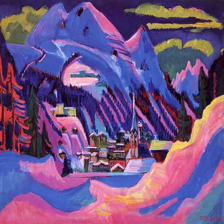

Class: impressionism
Probability: 48.80 %

Class: expressionism
Probability: 25.57 %

Class: romanticism
Probability: 21.59 %

Class: baroque
Probability: 2.46 %

Class: renaissance
Probability: 1.57 %



In [20]:
import os
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image

# Model
url = "https://www.artyfactory.com/art_appreciation/art_movements/art-movements/expressionism/kirchner.jpg" #@param {type:"string"}
os.system(f"wget -P /content/ -O image.png {url}")

image_PIL = Image.open("image.png")
image_PIL = image_PIL.resize((224,224))
display(image_PIL) 
image_PIL = image_PIL.resize((64,64))

image_Tensor = torchvision.transforms.functional.to_tensor(image_PIL) 
image_Tensor = image_Tensor.unsqueeze(0)

classes = test_dataloader.dataset.classes

with torch.no_grad():
  outputs = model(image_Tensor)
  _, predicted = outputs.topk(5)
  predicted_list = predicted.tolist()
  prob = torch.nn.functional.softmax(outputs, dim=1)
  top_prob, top_class = prob.topk(5, dim = 1)
  for i in range(5):
    print(f"Class: {classes[top_class[0][i]]}")
    print(f"Probability: {top_prob[0][i]*100:.2f} %")
    print("")

  # collect the correct predictions for each class